<a href="https://colab.research.google.com/github/nishantgovil03/Research/blob/master/Summary_3_Layered_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd


'/content'

In [3]:
%ls 

drive/  sample_data/


In [4]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [5]:
import pandas as pd

In [6]:
data = pd.read_csv("InputData.csv")

In [7]:
data

,Unnamed: 0,Articles without stop words,Article with stop words,Summary
0,0,budget set scene electiongordon brown seek put...,budget to set scene for electiongordon brown w...,<START> increase in the stamp duty threshold f...
1,1,army chiefs regiments decisionmilitary chiefs ...,army chiefs in regiments decisionmilitary chie...,<START> they are very much not for the good an...
2,2,howard denies split id cardsmichael howard den...,howard denies split over id cardsmichael howar...,<START> michael howard has denied his shadow c...
3,3,observers monitor uk electionministers invite ...,observers to monitor uk electionministers will...,<START> the report said individual registratio...
4,4,kilroy names election seat show host robert co...,kilroy names election seat show host robert is...,<START> ukip roger has said he is glad to see ...
...,...,...,...,...
4445,4445,india opens skies competitionindia allow domes...,india opens skies to competitionindia will all...,<START> india will allow domestic commercial a...
4446,4446,yukos bankruptcy us authorities abide us court...,yukos bankruptcy us authorities do not have to...,<START> yukos says a us court was entitled to ...
4447,4447,survey confirms property slowdowngovernment fi...,survey confirms property slowdowngovernment fi...,<START> house prices were higher on the year i...
4448,4448,high fuel prices hit ba profitsbritish airways...,high fuel prices hit ba profitsbritish airways...,<START> rod ba chief said the results were res...


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split

In [9]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


In [10]:
max_art_len=500
max_sum_len=100

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

art_vocab_size=len(article_tokenizer.word_index)+1

In [13]:
art_vocab_size

24225

In [14]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [15]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 500) (1335, 500)


In [16]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

sum_vocab_size=len(summary_tokenizer.word_index)+1

In [17]:
sum_vocab_size

15775

In [18]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [19]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [20]:
embedding_size = 100
n_units = 300

In [21]:
#model = models.Sequential()
#model.add(layers.Dense(16, activation='relu',input_shape=(max_art_len,)))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dense(16, activation='relu'))

In [35]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,embedding_size,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)

encoder_lstm2=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM2')
enclstm2_outputs,enclstm2_h,enclstm2_c=encoder_lstm2(enclstm1_outputs)

encoder_lstm3=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM3')
enclstm3_outputs,enclstm3_h,enclstm3_c=encoder_lstm3(enclstm2_outputs)

decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,embedding_size,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm3_h,enclstm3_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
Encoder_Embedding_layer (Embedd (None, 500, 100)     2422500     input_5[0][0]                    
__________________________________________________________________________________________________
Encoder_LSTM1 (LSTM)            [(None, 500, 300), ( 481200      Encoder_Embedding_layer[0][0]    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [33]:
#encoder_inputs=Input(shape=(max_art_len,))
#encoder_emb=Embedding(art_vocab_size,embedding_size,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
#encoder_lstm1=Bidirectional(LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM1'))
#enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)

#encoder_lstm2=Bidirectional(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM2')
#enclstm2_outputs,enclstm2_h,enclstm2_c=encoder_lstm2(enclstm1_outputs)

#encoder_lstm3=Bidirectional(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM3')
#enclstm3_outputs,enclstm3_h,enclstm3_c=encoder_lstm3(enclstm2_outputs)

#decoder_inputs=Input(shape=(None,))
#decoder_em=Embedding(sum_vocab_size,embedding_size,trainable=True,name='Decoder_Embedding_layer')
#decoder_emb=decoder_em(decoder_inputs)

#decoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Decoder_LSTM1')
#declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm3_h,enclstm3_c])

#output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
#output=output_layer(declstm1_output)

#model=Model([encoder_inputs,decoder_inputs],output)

#model.summary()

ValueError: ignored

In [36]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [37]:
history = model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=30,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

Epoch 1/30
49/49 [==============================] - 29s 492ms/step - loss: 8.4326 - accuracy: 0.0833 - val_loss: 6.6862 - val_accuracy: 0.0914
Epoch 2/30
49/49 [==============================] - 23s 476ms/step - loss: 6.6651 - accuracy: 0.0852 - val_loss: 6.6485 - val_accuracy: 0.0914
Epoch 3/30
49/49 [==============================] - 24s 487ms/step - loss: 6.6209 - accuracy: 0.0857 - val_loss: 6.6123 - val_accuracy: 0.1330
Epoch 4/30
49/49 [==============================] - 24s 481ms/step - loss: 6.5459 - accuracy: 0.1178 - val_loss: 6.3313 - val_accuracy: 0.1518
Epoch 5/30
49/49 [==============================] - 23s 479ms/step - loss: 6.3087 - accuracy: 0.1435 - val_loss: 6.1961 - val_accuracy: 0.1572
Epoch 6/30
49/49 [==============================] - 24s 482ms/step - loss: 6.1751 - accuracy: 0.1549 - val_loss: 6.1237 - val_accuracy: 0.1669
Epoch 7/30
49/49 [==============================] - 24s 484ms/step - loss: 6.1003 - accuracy: 0.1592 - val_loss: 6.0723 - val_accuracy: 0.1684

In [38]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
import matplotlib.pyplot as plt

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [46]:
epochs = range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

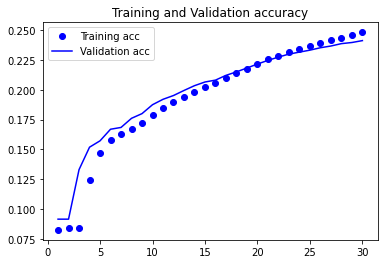

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(epochs , acc , 'bo' ,  label = 'Training acc')
plt.plot(epochs , val_acc , 'b' ,  label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()


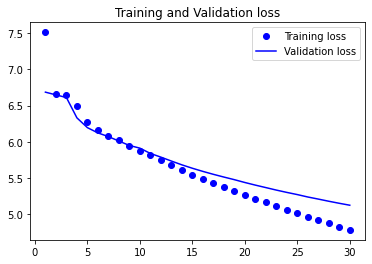

In [48]:
plt.plot(epochs , loss , 'bo' ,  label = 'Training loss')
plt.plot(epochs , val_loss , 'b' ,  label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
